<a href="https://colab.research.google.com/github/Le4o/topicos-avancados-ic/blob/main/Avalia%C3%A7%C3%A3o_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais
#### Exercício da matéria de Tópicos Avançados em Inteligência Computacional

Grupo:
- João Victor de Sledz Bulhões
- Leonardo de Andrade Santana
- Lis da Silva Azevedo

### Definição do Exercício
Utilizaremos o banco de dados do Human Activity Recognition with Smartphones, que foi construído a partir das gravações dos participantes do estudo realizando atividades da vida diária enquanto carregavam um smartphone com sensores inerciais embutidos. Para cada registro no conjunto de dados, é fornecido:

- Aceleração triaxial do acelerômetro (aceleração total) e a aceleração corporal estimada.

- Velocidade angular triaxial do giroscópio.

- Um vetor de 561 atributos com variáveis de domínio de tempo e frequência.

- O rótulo da atividade.

### Objetivo:
* Construir um modelo robusto para classificação das atividades diárias, utilizando o banco de dados fornecido, em uma das seis ações disponíveis:

> 1. caminhar;
> 2. subir escadas;
> 3. descer escadas;
> 4. sentar;
> 5. ficar em pé;
> 6. deitar.

* Considere a divisão entre treinamento, validação e teste de 50%, 25% e 25%, respectivamente.

* Desenvolver 4 modelos, utilizando:
> 1. MLP
> 2. CNN
> 3. Rede Neural Recorrente
> 4. Arquitetura hibrida com a combinação das redes anteriores


* Utilizar como métricas: **precision, recall, specificity,
F1-Score e accuracy**, evidenciando que o modelo não sofreu de **over/underfitting**.

### Observação: 
*   *Considere a divisão entre treinamento, validação e teste de
50%, 25% e 25%, respectivamente;*
*   *Apresentação de métricas, gráficos, são essenciais para entendimento dos modelos e justificativas.*
*   *Compare ao final em uma tabela e apresente que técnica obteve os melhores
resultados, discutindo-os à luz de seu conhecimento sobre o assunto, discutindo
se eram resultados esperados, se estão adequados, e os porquês.*

### Opcionais:

*   A utilização de redes neurais baseadas em transformers é opcional e adicionará **1,0 ponto extra** ao projeto.
*   A utilização de pré-processamento das séries com Wavelets OU transformadas de Fourier adicionará **1,0 ponto extra** ao projeto.


### Link:

* [Mais informações sobre os recursos estão disponíveis no site](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) 


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Datasets

Mounted at /content/drive/
/content/drive/My Drive/Datasets


In [ ]:
import numpy as np 
import pandas as pd 

## Carregando os dados

O dataset fornecido é segmentado em **70% treino e 30% teste**, porém a atividade pede para segmentar em: **50% treino, 25% validação e 25% teste.** Então nos primeiramente juntamos os dados.


In [ ]:
# Carregando os dados diretamente dos csvs do Human Activity Recognition with Smartphones
train_data = pd.read_csv('./uci_har_csvs/train.csv')
test_data = pd.read_csv('./uci_har_csvs/test.csv')

print(f'Shape of train data is: {train_data.shape}\nShape of test data is: {test_data.shape}')

data = train_data.append(test_data)
data.shape

print(f'Shape of combined data is {data.shape}')

Shape of train data is: (7352, 563)
Shape of test data is: (2947, 563)
Shape of combined data is (10299, 563)


## Analise inicial dos dados

O dataset possui 6 classes, sendo elas:


1.   Walking downstairs
2.   Walking Upstairs
3.   Walking
4.   Sitting
5.   Stading 
6.   Laying



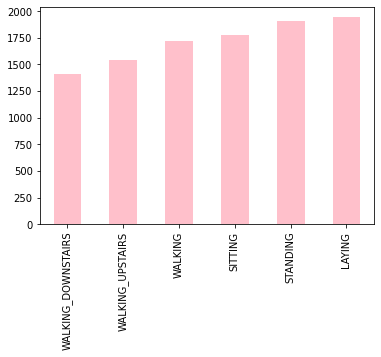

In [ ]:
data['Activity'].value_counts().sort_values().plot(kind = 'bar', color = 'pink')

In [ ]:
train, validate, test = \
              np.split(data.sample(frac=1, random_state=42), 
                       [int(.5*len(data)), int(.75*len(data))])
              
print(f'Shape of train data is {train.shape}')
print(f'Shape of validation data is {validate.shape}')
print(f'Shape of test data is {test.shape}')

Shape of train data is (5149, 563)
Shape of validation data is (2575, 563)
Shape of test data is (2575, 563)
